In [1]:
import os
import cv2
import torch
import torchvision
import tensorflow
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from skimage import io
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.datasets as datasets
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from skimage.metrics import structural_similarity as ssim

In [2]:
train=datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test=datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


10

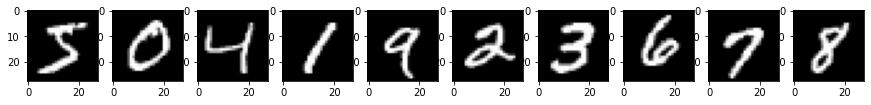

In [3]:
n=0
i=0
digits=[]
true_images=[]
while(n<10):
    if(train[i][1] not in digits):
        true_images.append(train[i][0][0].numpy())
        digits.append(train[i][1])
        n=n+1
    i=i+1
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(true_images):
    axs[n].imshow(i,cmap="gray")
len(true_images)

In [75]:
def ssim_loss(pred,target):
    l=[]
    for x ,y in zip(pred,target):   
        mx=torch.mean(x)
        stdx=torch.std(x)
        my=torch.mean(y)
        stdy=torch.std(y)
        covxy=torch.sum((x-mx)*(y-my))
        covxy=covxy/783
        sm=mx*mx+my*my
        sstd=stdx*stdx+stdy*stdy
        ssim=(2*mx*my*2*covxy)/(sm*sstd)
        l.append(-ssim)
    sum=0
    for i in l:
        sum=sum+i
    return sum/len(l)
    



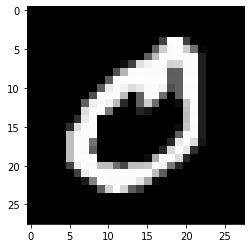

In [5]:
plt.imshow(train[21][0][0].numpy(),cmap="gray")

In [6]:
train_dl = torch.utils.data.DataLoader(train, 64, shuffle=True)

In [81]:
class encoderNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(encoderNet, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms)
        )

    def forward(self, x):
        return self.enc(x)

class decoderNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(decoderNet, self).__init__()
        self.dec = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.dec(x)

class discriminatorNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(discriminatorNet, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [82]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder=encoderNet(784,1000,2).to(DEVICE)
decoder=decoderNet(2,1000,784).to(DEVICE)
discriminator=discriminatorNet(2,500,1).to(DEVICE)

In [83]:
DEVICE

'cuda'

In [84]:
Rleoptimizer = optim.Adam(encoder.parameters(), lr=0.0001)
Rldoptimizer = optim.Adam(decoder.parameters(), lr=0.0001)
Doptimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
adoptimizer = optim.Adam(encoder.parameters(), lr=0.00005)

In [85]:
def validate(loader, encoder,decoder,discriminator ,loss_func,DEVICE="cuda"):
    EPS = 1e-10
    encoder.eval()
    decoder.eval()
    discriminator.eval()
    l=[]
    dl=[]
    with torch.no_grad():
        for images, y in loader:
            images=images.view(images.shape[0],-1)
            images = images.to(device=DEVICE)
            en_images=encoder(images)
            de_images=decoder(en_images)
            loss = loss_fn(de_images, images)
            loss=loss.to("cpu")
            loss=loss.numpy()
            loss=loss.reshape(1)
            l.append(loss[0])
            z_true= torch.randn(images.shape[0], 2).to(DEVICE)
            D_true = discriminator(z_true)
            z_fake = en_images
            D_fake =  discriminator(z_fake)
            D_loss = -torch.mean(torch.log(D_true+EPS) + torch.log(1 - D_fake+EPS))
            D_loss = D_loss.to("cpu")
            D_loss=D_loss.numpy()
            D_loss=D_loss.reshape(1)
            dl.append(D_loss[0])
    l=np.array(l)
    dl=np.array(dl)
    encoder.train()
    decoder.train()
    discriminator.train()
    return np.mean(l),np.mean(dl)

In [86]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
def train_fn(loader,encoder,decoder,discriminator,loss_fn):
    EPS = 1e-15
    Rleoptimizer = optim.Adam(encoder.parameters(), lr=0.0001)
    Rldoptimizer = optim.Adam(decoder.parameters(), lr=0.0001)
    Doptimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
    adoptimizer = optim.Adam(encoder.parameters(), lr=0.00005)
    rl=[]
    dl=[]
    trloss, tdloss=validate(loader, encoder,decoder,discriminator ,loss_fn,DEVICE="cuda")
    rl.append(trloss)
    dl.append(tdloss)
    for epochs in range(100):
      loop = tqdm(loader)
      for batch_idx, (images, targets) in enumerate(loop):
          images=images.view(images.shape[0],-1)
          images = images.to(device=DEVICE)

         
          en_images=encoder(images)
          de_images=decoder(en_images)
          rloss=loss_fn(de_images,images)

          Rleoptimizer.zero_grad()
          Rldoptimizer.zero_grad()
          rloss.backward()
          Rleoptimizer.step()
          Rldoptimizer.step()

          encoder.eval()
          z_true= torch.randn(images.shape[0], 2).to(DEVICE)
          D_true = discriminator(z_true)

          z_fake = encoder(images)
          D_fake =  discriminator(z_fake)

          D_loss = -torch.mean(torch.log(D_true+EPS) + torch.log(1 - D_fake+EPS))
          Doptimizer.zero_grad()
          D_loss.backward()
          Doptimizer.step()
  

          encoder.train()
          z_fake = encoder(images)
          D_fake = discriminator(z_fake)
          
          ad_loss = -torch.mean(torch.log(D_fake+EPS))
          adoptimizer.zero_grad()
          ad_loss.backward()
          adoptimizer.step()   

          # update tqdm loop
          loop.set_postfix(loss=rloss.item())
      trloss, tdloss=validate(loader, encoder,decoder,discriminator ,loss_fn,DEVICE="cuda")
      rl.append(trloss)
      dl.append(tdloss)
    return rl,dl

In [87]:
loss_fn = nn.BCELoss()
bcerl,bcedl=train_fn(train_dl,encoder,decoder,discriminator,loss_fn)

100%|██████████| 938/938 [00:12<00:00, 74.27it/s, loss=0.195]


Text(0.5, 1.0, 'Reconstruction loss(BCEloss) Vs epochs')

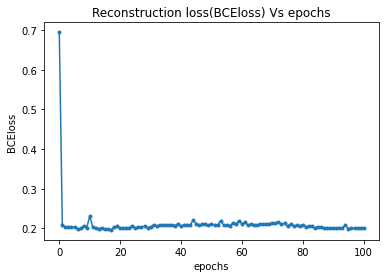

In [88]:
plt.plot(bcerl)
plt.scatter(range(0,len(bcerl)),bcerl,marker='.')
plt.ylabel("BCEloss")
plt.xlabel("epochs")
plt.title("Reconstruction loss(BCEloss) Vs epochs")

Text(0.5, 1.0, 'Discriminator loss Vs epochs')

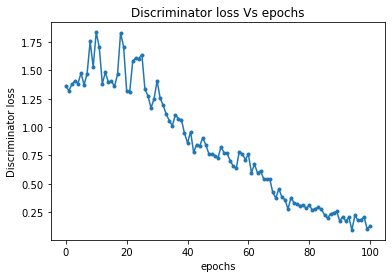

In [89]:

plt.plot(bcedl)
plt.scatter(range(0,len(bcerl)),bcedl,marker='.')
plt.ylabel("Discriminator loss")
plt.xlabel("epochs")
plt.title("Discriminator loss Vs epochs")

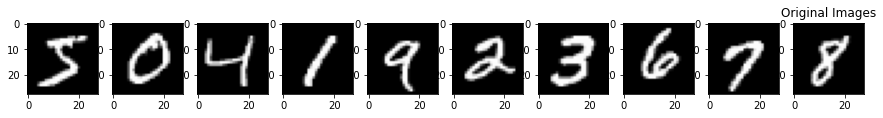

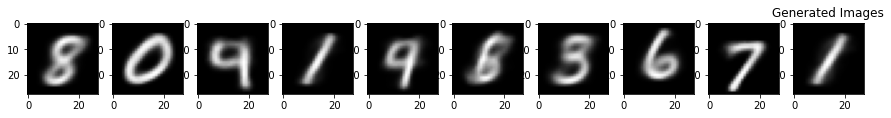

In [23]:
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(true_images):
    axs[n].imshow(i,cmap="gray")
    plt.title("Original Images")
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for n, x in enumerate(true_images):
    x=torch.tensor([x])
    x=x.view(x.shape[0],-1)
    x=x.cuda()
    x=encoder(x)
    y=discriminator(x)
    x=decoder(x)
    x=x[0].cpu().detach().numpy()
    x=x.reshape(28,28)
    axs[n].imshow(x,cmap="gray")
    plt.title("Generated Images")


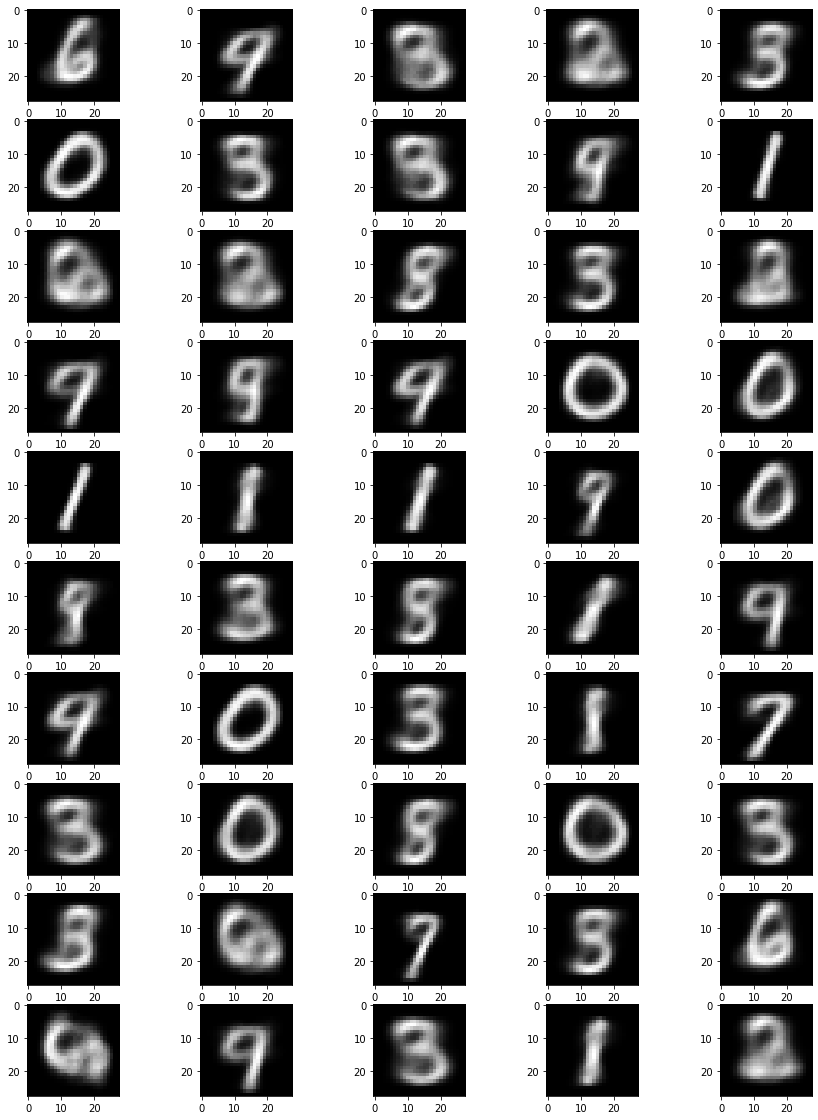

In [17]:
fig, axs = plt.subplots(10,5, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
x=torch.randn(50, 2).to(DEVICE)
for n, i in enumerate(x):
    i=decoder(i)
    i=i.cpu().detach().numpy()
    i=i.reshape(28,28)
    axs[n].imshow(i,cmap="gray")

In [47]:
class encoderNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(encoderNet, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms)
        )

    def forward(self, x):
        return self.enc(x)

class decoderNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(decoderNet, self).__init__()
        self.dec = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms),
            nn.ReLU()
        )

    def forward(self, x):
        return self.dec(x)

class discriminatorNet(nn.Module):
    def __init__(self, indms, nodes,outdms):
        super(discriminatorNet, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(indms,nodes),
            nn.ReLU(),
            nn.Linear(nodes,nodes),
            nn.ReLU(),
            nn.Linear(nodes,outdms),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [48]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder=encoderNet(784,1000,2).to(DEVICE)
decoder=decoderNet(2,1000,784).to(DEVICE)
discriminator=discriminatorNet(2,500,1).to(DEVICE)

In [49]:
loss_fn = nn.MSELoss()
mserl,msedl=train_fn(train_dl,encoder,decoder,discriminator,loss_fn)

100%|██████████| 938/938 [00:12<00:00, 74.61it/s, loss=0.0446]


Text(0.5, 1.0, 'Reconstruction loss(MSEloss) Vs epochs')

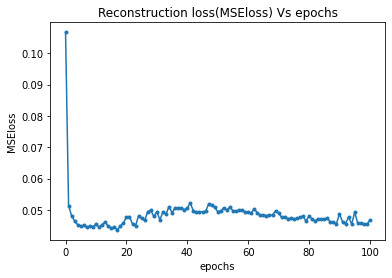

In [53]:
plt.plot(mserl)
plt.scatter(range(0,len(mserl)),mserl,marker='.')
plt.ylabel("MSEloss")
plt.xlabel("epochs")
plt.title("Reconstruction loss(MSEloss) Vs epochs")

Text(0.5, 1.0, 'Disriminator loss(MSEloss) Vs epochs')

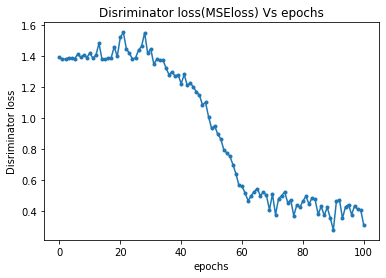

In [54]:
plt.plot(msedl)
plt.scatter(range(0,len(msedl)),msedl,marker='.')
plt.ylabel("Disriminator loss")
plt.xlabel("epochs")
plt.title("Disriminator loss(MSEloss) Vs epochs")

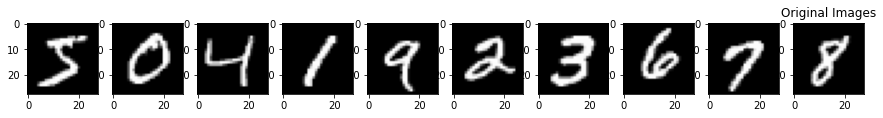

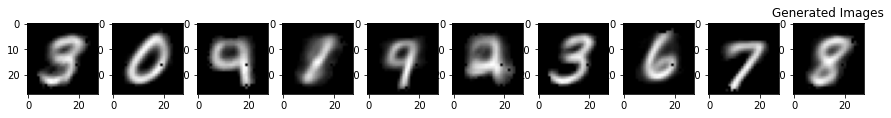

In [55]:
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(true_images):
    axs[n].imshow(i,cmap="gray")
    plt.title("Original Images")
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for n, x in enumerate(true_images):
    x=torch.tensor([x])
    x=x.view(x.shape[0],-1)
    x=x.cuda()
    x=encoder(x)
    y=discriminator(x)
    x=decoder(x)
    x=x[0].cpu().detach().numpy()
    x=x.reshape(28,28)
    axs[n].imshow(x,cmap="gray")
    plt.title("Generated Images")


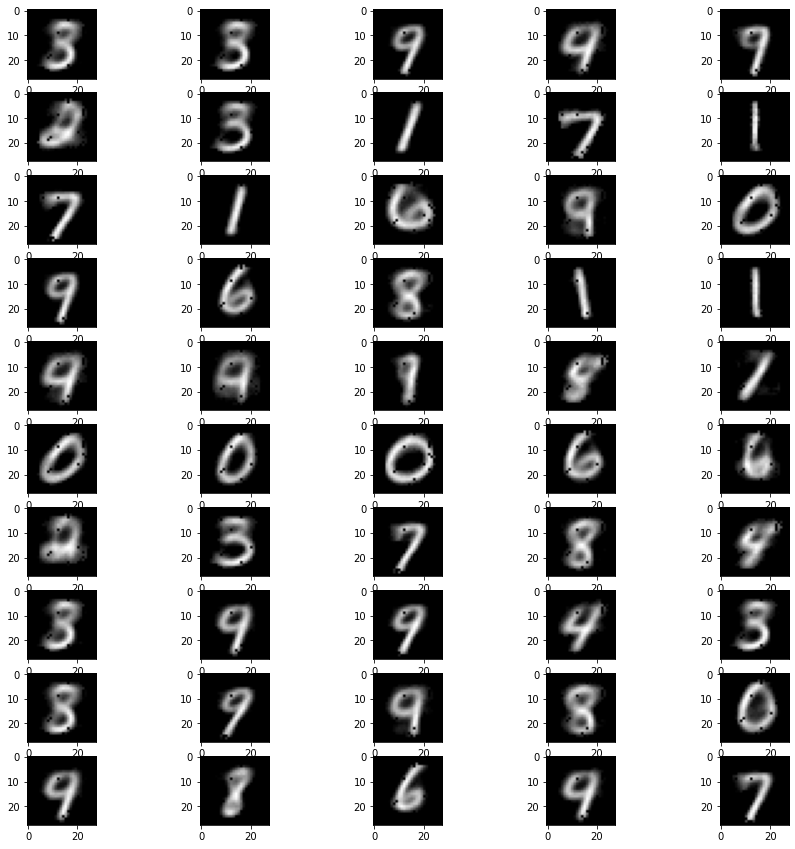

In [38]:
fig, axs = plt.subplots(10,5, figsize=(15, 15), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
x=torch.randn(50, 2).to(DEVICE)
for n, i in enumerate(x):
    i=decoder(i)
    i=i.cpu().detach().numpy()
    i=i.reshape(28,28)
    axs[n].imshow(i,cmap="gray")

In [76]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
encoder=encoderNet(784,1000,2).to(DEVICE)
decoder=decoderNet(2,1000,784).to(DEVICE)
discriminator=discriminatorNet(2,500,1).to(DEVICE)

In [77]:
loss_fn = ssim_loss
ssimrl,ssimdl=train_fn(train_dl,encoder,decoder,discriminator,loss_fn)

100%|██████████| 938/938 [00:52<00:00, 17.87it/s, loss=-.669]


Text(0.5, 1.0, 'Reconstruction loss(MSEloss) Vs epochs')

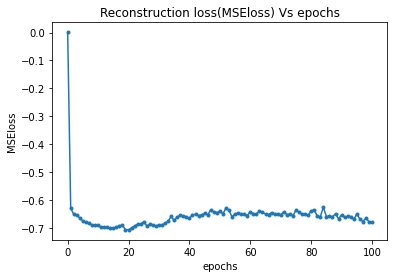

In [78]:
plt.plot(ssimrl)
plt.scatter(range(0,len(ssimrl)),ssimrl,marker='.')
plt.ylabel("MSEloss")
plt.xlabel("epochs")
plt.title("Reconstruction loss(MSEloss) Vs epochs")

Text(0.5, 1.0, 'Disriminator loss(MSEloss) Vs epochs')

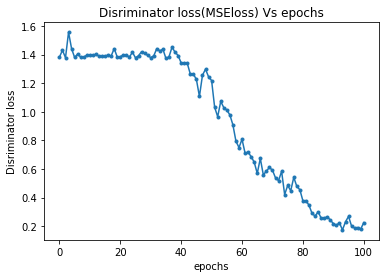

In [79]:
plt.plot(ssimdl)
plt.scatter(range(0,len(ssimdl)),ssimdl,marker='.')
plt.ylabel("Disriminator loss")
plt.xlabel("epochs")
plt.title("Disriminator loss(MSEloss) Vs epochs")

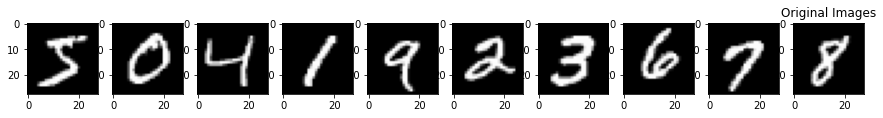

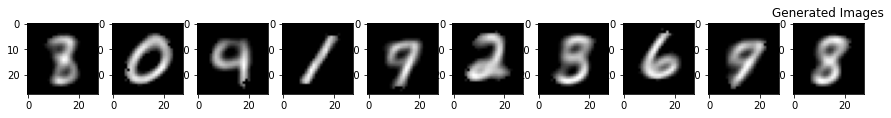

In [80]:
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(true_images):
    axs[n].imshow(i,cmap="gray")
    plt.title("Original Images")
fig, axs = plt.subplots(1,10, figsize=(15, 20), facecolor='w', edgecolor='k')
axs = axs.ravel()
for n, x in enumerate(true_images):
    x=torch.tensor([x])
    x=x.view(x.shape[0],-1)
    x=x.cuda()
    x=encoder(x)
    y=discriminator(x)
    x=decoder(x)
    x=x[0].cpu().detach().numpy()
    x=x.reshape(28,28)
    axs[n].imshow(x,cmap="gray")
    plt.title("Generated Images")


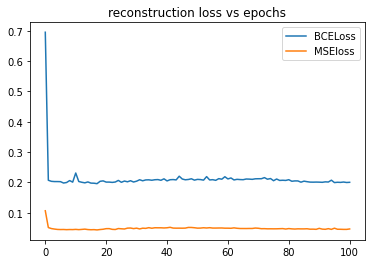

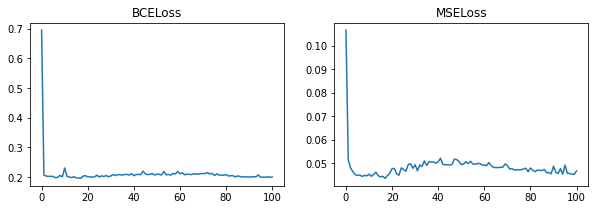

In [104]:
l=[bcerl,mserl]
plt.plot(bcerl)
plt.plot(mserl)
plt.title("reconstruction loss vs epochs")
plt.legend(["BCELoss","MSEloss","SSIMloss"])
fig, axs = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k')
axs = axs.ravel()
m=[]
for n, i in enumerate(l):
    axs[n].plot(i)
axs[0].title.set_text('BCELoss')
axs[1].title.set_text('MSELoss')

In [ ]:
 BCE loss has low values so it could be possible to use for most effeciency.